##### About the problem statement

Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. We might have often heard travellers saying that flight ticket prices are so unpredictable. Here you will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities.

##### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

#### Loading the train dataset

In [2]:
df = pd.read_excel("Data_Train.xlsx")
df.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


#### Checking for null values

In [3]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

#### Route and Total_stops have one missing value

#### Bivariate analysis for finding the relationship between Route and Price

<AxesSubplot:xlabel='Route', ylabel='Price'>

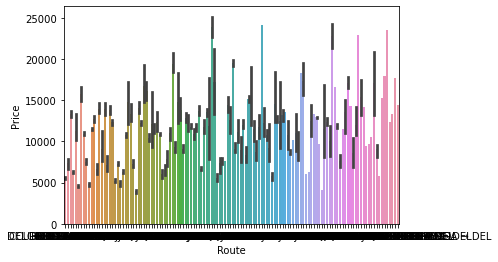

In [4]:
sns.barplot(x="Route",y="Price",data=df)

#### Analysing the relationship between Total_Stops and Price

<AxesSubplot:xlabel='Total_Stops', ylabel='Price'>

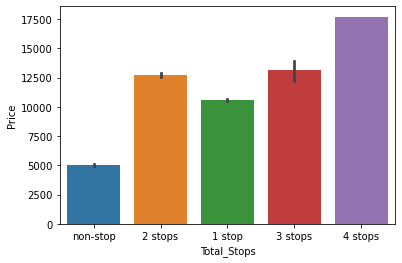

In [5]:
sns.barplot(x="Total_Stops",y="Price",data=df)

#### As the number of stops increases the price also increases

#### Dealing with the null values
#### We just have two null values , so dropping that

In [6]:
df['Total_Stops'].dropna(axis=0,inplace=True)
df['Route'].dropna(axis=0,inplace=True)

In [7]:
df.shape

(10683, 11)

#### To extract day, month and time, converting the columns 'Date_of_Journey','Arrival_Time','Dep_Time' to DateTime

In [8]:
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])
df['Arrival_Time']=pd.to_datetime(df['Arrival_Time'])
df['Dep_Time']=pd.to_datetime(df['Dep_Time'])

#### Extracting day and month from Date_of_Journey

In [9]:
df['Day'] = df['Date_of_Journey'].dt.day
df['Month'] = df['Date_of_Journey'].dt.month
df = df.drop('Date_of_Journey',axis=1)

#### Extracting hour and minute from Arrival_Time and Dep_Time

In [10]:
df['Dep_Hour'] = df['Dep_Time'].dt.hour
df['Dep_Minute'] = df['Dep_Time'].dt.minute
df['Arrival_Hour'] = df['Arrival_Time'].dt.hour
df['Arrival_Minute'] = df['Arrival_Time'].dt.hour
df=df.drop('Arrival_Time',axis=1)
df=df.drop('Dep_Time',axis=1)

In [11]:
df.head(3)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,1
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,13
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,9,25,4,4


In [12]:
df.shape

(10683, 14)

### EDA

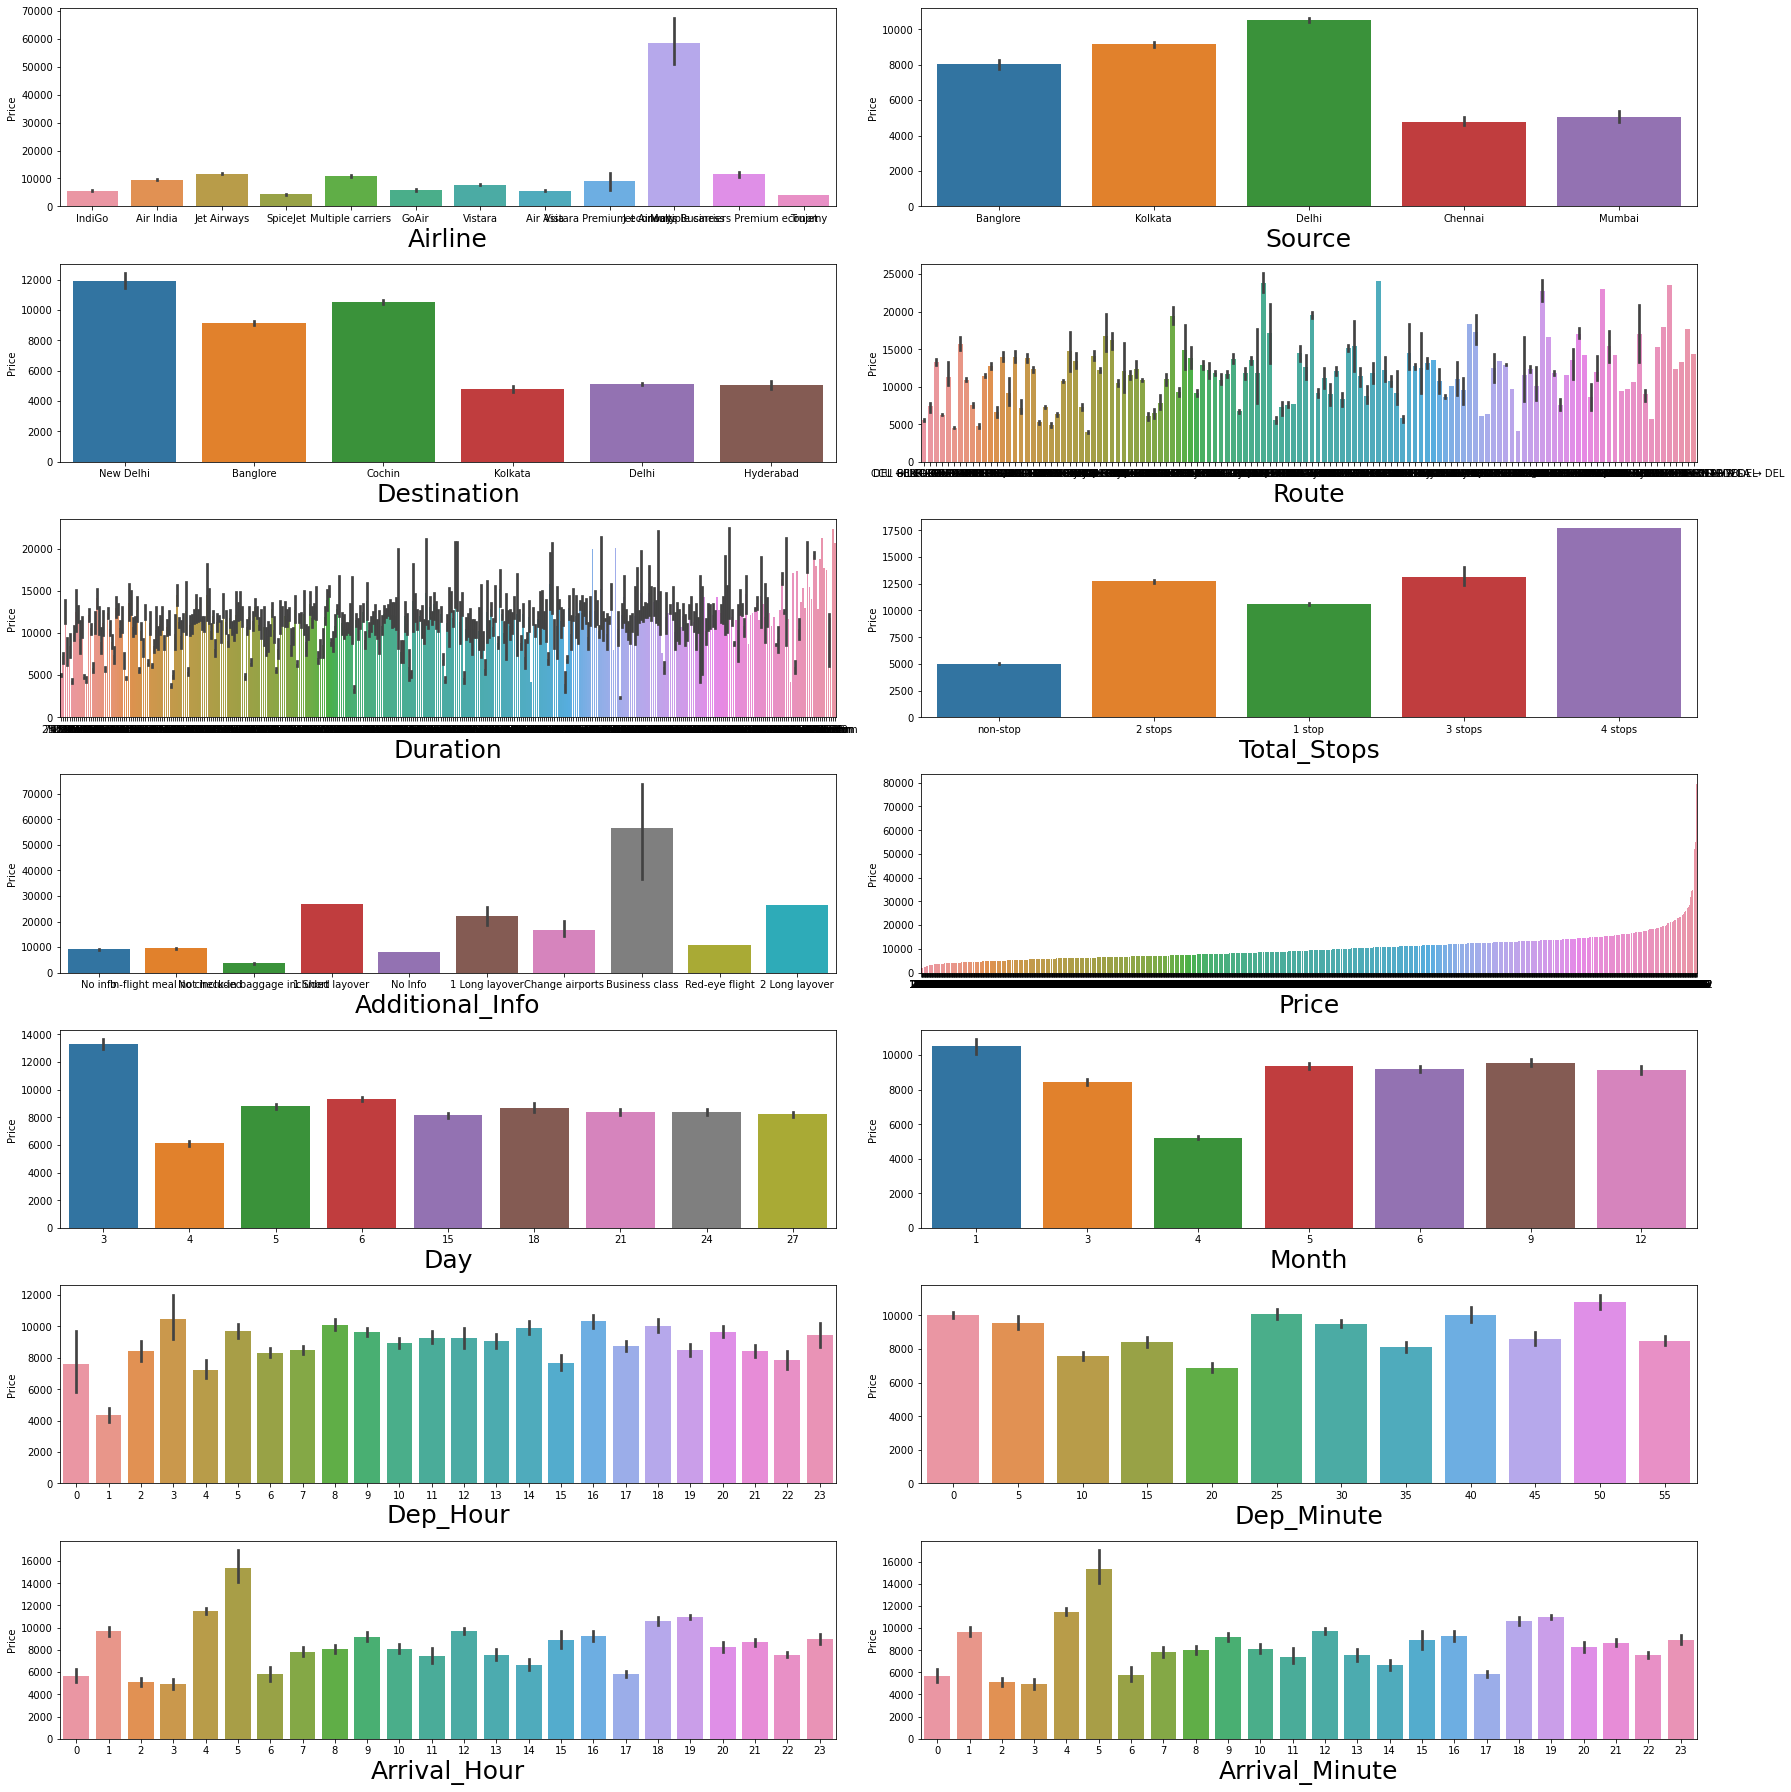

In [13]:
plt.figure(figsize=(25,25),facecolor="white")
plotnumber=1
for column in df:
    if plotnumber<=14:
        ax=plt.subplot(7,2,plotnumber)
        sns.barplot(x=df[column],y=df['Price'],data=df)
        plt.xlabel(column,fontsize=25)
    plotnumber+=1
plt.tight_layout()

#### From the above graph it is clear that Jet Airways Business charges the highest price
#### Price is at its peak when Delhi is the source followed by Kolkata
#### Price is high if destination is Delhi followed by Cochin
#### As number of stops increases Price also increase
#### Price is highest for Business Class followed by 1 short layover
#### On 1st of every month Price is high
#### On the first month Price is high
#### Price is high on the fifth hour

#### Checking the datatype

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Source           10683 non-null  object
 2   Destination      10683 non-null  object
 3   Route            10682 non-null  object
 4   Duration         10683 non-null  object
 5   Total_Stops      10682 non-null  object
 6   Additional_Info  10683 non-null  object
 7   Price            10683 non-null  int64 
 8   Day              10683 non-null  int64 
 9   Month            10683 non-null  int64 
 10  Dep_Hour         10683 non-null  int64 
 11  Dep_Minute       10683 non-null  int64 
 12  Arrival_Hour     10683 non-null  int64 
 13  Arrival_Minute   10683 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 1.1+ MB


#### Finding the categorical columns

In [15]:
cat_col = [column for column in df.columns if df[column].dtype=='object']
cat_col

['Airline',
 'Source',
 'Destination',
 'Route',
 'Duration',
 'Total_Stops',
 'Additional_Info']

#### Finding the continuous column

In [16]:
cont_col = [column for column in df.columns if df[column].dtype!='object']
cont_col

['Price',
 'Day',
 'Month',
 'Dep_Hour',
 'Dep_Minute',
 'Arrival_Hour',
 'Arrival_Minute']

#### Now we need to convert Categorical columns to numerical by encoding techniques

#### For Nominal columns lets use OneHotEncoding techniques and for ordinal lets use LabelEncoding

In [17]:
categorical = df[cat_col]

In [18]:
Airline=pd.get_dummies(categorical[['Airline','Source','Destination']],drop_first=True)

In [19]:
Airline

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10679,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10680,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10681,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


#### Using Label encoding techniques for other columns

In [20]:
lab_enc = LabelEncoder()
for i in ['Route','Duration','Total_Stops','Additional_Info']:
    categorical[i]=lab_enc.fit_transform(categorical[i])

In [21]:
categorical.head(3)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,18,240,4,8
1,Air India,Kolkata,Banglore,84,336,1,8
2,Jet Airways,Delhi,Cochin,118,106,1,8


In [22]:
df = pd.concat([categorical,Airline,df[cont_col]],axis=1)
df.head(3)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Price,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,18,240,4,8,0,0,1,...,0,0,1,3897,24,3,22,20,1,1
1,Air India,Kolkata,Banglore,84,336,1,8,1,0,0,...,0,0,0,7662,5,1,5,50,13,13
2,Jet Airways,Delhi,Cochin,118,106,1,8,0,0,0,...,0,0,0,13882,6,9,9,25,4,4


#### Dropping Airline, Source and Destination as we have encoded that

In [23]:
df = df.drop(columns=['Airline','Source','Destination'],axis=1)
df.head(3)

,Route,Duration,Total_Stops,Additional_Info,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Price,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,18,240,4,8,0,0,1,0,0,0,...,0,0,1,3897,24,3,22,20,1,1
1,84,336,1,8,1,0,0,0,0,0,...,0,0,0,7662,5,1,5,50,13,13
2,118,106,1,8,0,0,0,1,0,0,...,0,0,0,13882,6,9,9,25,4,4


#### Finding the correlation

In [24]:
df.corr()

,Route,Duration,Total_Stops,Additional_Info,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Price,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
Route,1.000000,-0.062111,-0.437362,0.035216,0.018813,-0.065505,-0.029017,-0.073699,-0.022369,0.292604,...,-0.195213,0.273182,-0.526135,0.164085,0.096470,0.042211,-0.075076,-0.067912,0.013811,0.013811
Duration,-0.062111,1.000000,0.175106,0.080151,-0.087415,0.116740,0.163625,-0.121744,0.028358,-0.068265,...,-0.166020,0.070565,0.007484,-0.144270,0.024767,-0.038864,0.041523,0.030845,0.024527,0.024527
Total_Stops,-0.437362,0.175106,1.000000,0.164114,-0.006917,0.032999,0.261518,-0.262394,-0.014766,-0.276985,...,0.315024,0.270549,-0.021924,-0.571179,0.043674,-0.056475,0.039105,0.049090,-0.095748,-0.095748
Additional_Info,0.035216,0.080151,0.164114,1.000000,0.202877,0.067984,0.242644,-0.549673,-0.036961,0.107072,...,0.021554,0.071191,-0.038612,-0.065478,-0.019456,-0.009098,-0.051010,-0.019339,0.026173,0.026173
Airline_Air India,0.018813,-0.087415,-0.006917,0.202877,1.000000,-0.060235,-0.216026,-0.332394,-0.010499,-0.157260,...,0.022206,-0.051097,0.052993,0.050346,-0.037453,-0.000248,-0.013004,-0.045442,0.088716,0.088716
Airline_GoAir,-0.065505,0.116740,0.032999,0.067984,-0.060235,1.000000,-0.066332,-0.102063,-0.003224,-0.048288,...,-0.035930,-0.026154,0.017576,-0.095146,0.002361,-0.017540,-0.016365,0.076733,0.018534,0.018534
Airline_IndiGo,-0.029017,0.163625,0.261518,0.242644,-0.216026,-0.066332,1.000000,-0.366037,-0.011562,-0.173177,...,0.059697,0.141918,-0.018612,-0.361048,0.013262,-0.037210,-0.023367,-0.014763,-0.071459,-0.071459
Airline_Jet Airways,-0.073699,-0.121744,-0.262394,-0.549673,-0.332394,-0.102063,-0.366037,1.000000,-0.017790,-0.266463,...,-0.025363,-0.144324,0.056802,0.416135,-0.028324,0.057805,0.113980,0.024376,-0.027332,-0.027332
Airline_Jet Airways Business,-0.022369,0.028358,-0.014766,-0.036961,-0.010499,-0.003224,-0.011562,-0.017790,1.000000,-0.008417,...,-0.006263,-0.004559,0.048675,0.253302,-0.026072,-0.026727,-0.007522,0.009165,-0.014454,-0.014454
Airline_Multiple carriers,0.292604,-0.068265,-0.276985,0.107072,-0.157260,-0.048288,-0.173177,-0.266463,-0.008417,1.000000,...,-0.093804,-0.068281,-0.109770,0.139803,0.048665,-0.002742,-0.149969,-0.109400,0.067949,0.067949


#### Total_Stops is highly correlated Price and Dep_Hour is least correlated with Price

#### Statistical Analysis

In [25]:
df.describe()

,Route,Duration,Total_Stops,Additional_Info,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Price,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
count,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,...,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000
mean,74.825143,194.069269,1.458579,7.393054,0.163999,0.018160,0.192174,0.360292,0.000562,0.111954,...,0.065244,0.035664,0.087241,9087.064121,12.682205,5.534775,12.490686,24.411214,13.348778,13.348778
std,36.730924,108.620556,1.806560,1.214211,0.370292,0.133535,0.394028,0.480108,0.023693,0.315324,...,0.246967,0.185460,0.282202,4611.359167,8.803701,2.987489,5.748650,18.767980,6.859125,6.859125
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1759.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,106.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5277.000000,5.000000,3.000000,8.000000,5.000000,8.000000,8.000000
50%,73.000000,233.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8372.000000,6.000000,5.000000,11.000000,25.000000,14.000000,14.000000
75%,104.000000,280.000000,4.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,12373.000000,21.000000,6.000000,18.000000,40.000000,19.000000,19.000000
max,128.000000,367.000000,5.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,79512.000000,27.000000,12.000000,23.000000,55.000000,23.000000,23.000000


#### From the above table its almost clear that there is no outliers on the dataset

#### Checking for Outliers

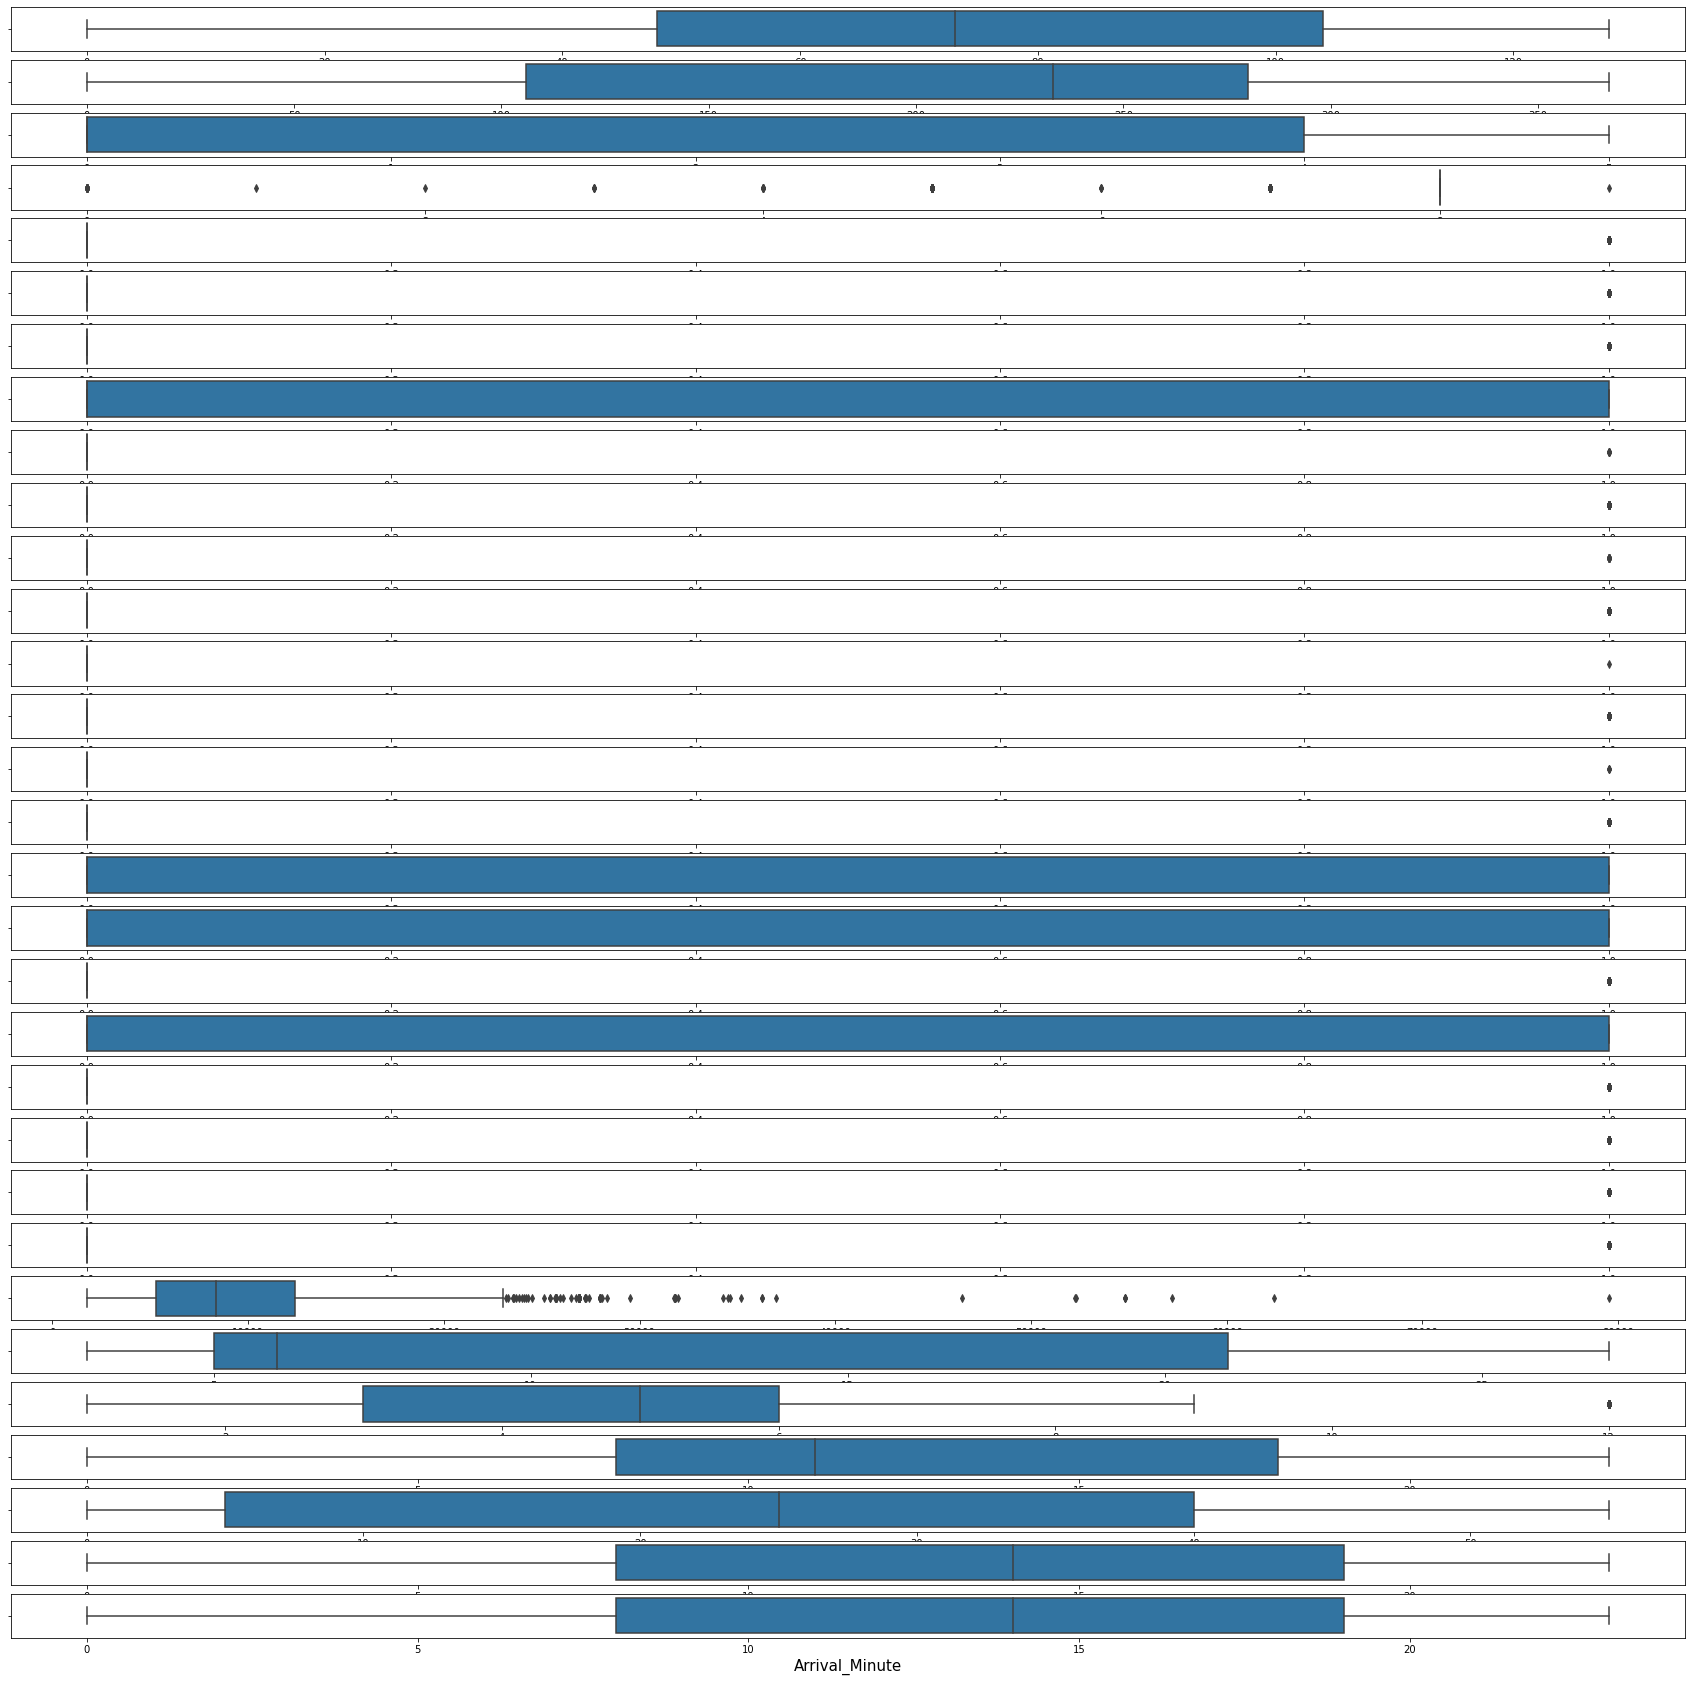

In [26]:
plt.figure(figsize=(30,30))
gr = 1
for column in df:
    if gr<=31:
        ax = plt.subplot(31,1,gr)
        sns.boxplot(df[column],orient='v')
        plt.xlabel(column,fontsize=15)
    gr+=1
plt.show()

#### The outliers exists 

#### Checking Skewness

In [27]:
df.skew()

Route                                         -0.501909
Duration                                      -0.213427
Total_Stops                                    0.631375
Additional_Info                               -1.779838
Airline_Air India                              1.815130
Airline_GoAir                                  7.218042
Airline_IndiGo                                 1.562748
Airline_Jet Airways                            0.582095
Airline_Jet Airways Business                  42.166335
Airline_Multiple carriers                      2.461716
Airline_Multiple carriers Premium economy     28.618184
Airline_SpiceJet                               3.185227
Airline_Trujet                               103.358599
Airline_Vistara                                4.399442
Airline_Vistara Premium economy               59.657352
Source_Chennai                                 5.008333
Source_Delhi                                   0.304745
Source_Kolkata                                 1

#### Skewness exists in the dataset

#### Removing the outliers by z-score

In [28]:
from scipy.stats import zscore
z = np.abs(zscore(df))
print("Old shape : ",z.shape)
print(z)
print("Row numbers : ",np.where(z>3)[0])
print("Column numbers : ",np.where(z>3)[0])
index = np.where(z>3)[0]
df1 = df.drop(df.index[index])
print("New shape : ",df1.shape)

Old shape :  (10683, 31)
[[1.54713785 0.42287466 1.40683915 ... 0.23505036 1.80042732 1.80042732]
 [0.24979733 1.30672664 0.25385286 ... 1.36349161 0.0508512  0.0508512 ]
 [1.17549121 0.81083539 0.25385286 ... 0.0313733  1.36303329 1.36303329]
 ...
 [1.54713785 0.79114632 1.40683915 ... 0.23505036 0.34244722 0.34244722]
 [1.54713785 0.40446108 1.40683915 ... 0.29779696 0.09494681 0.09494681]
 [0.9032283  1.40800134 0.25385286 ... 1.62991527 0.82393686 0.82393686]]
Row numbers :  [    0     4     5 ... 10677 10681 10681]
Column numbers :  [    0     4     5 ... 10677 10681 10681]
New shape :  (7588, 31)


#### Checking dataloss in percentage

In [29]:
loss = (10683-7588)/10683*100
print("While removing outliers we loss ",loss,"% of data")

While removing outliers we loss  28.97126275390808 % of data


#### We are losing too much of data, so continuing with the existing one and dropping the Additional_info column as it is having outliers

In [30]:
df = df.drop('Additional_Info',axis=1)
df.head(3)

,Route,Duration,Total_Stops,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,...,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Price,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,18,240,4,0,0,1,0,0,0,0,...,0,0,1,3897,24,3,22,20,1,1
1,84,336,1,1,0,0,0,0,0,0,...,0,0,0,7662,5,1,5,50,13,13
2,118,106,1,0,0,0,1,0,0,0,...,0,0,0,13882,6,9,9,25,4,4


#### Splitting the Dataset into x and y

In [31]:
x = df.drop('Price',axis=1)
y = df['Price']

#### Removing Skewness

In [32]:
from sklearn.preprocessing import power_transform
x_new = power_transform(x,method='yeo-johnson')
x_new

array([[-1.53353435,  0.4598656 ,  1.29335859, ...,  0.02304928,
        -1.79077259, -1.79077259],
       [ 0.23045613,  1.23977462,  0.35515174, ...,  1.17929081,
        -0.05592099, -0.05592099],
       [ 1.19954316, -0.74655475,  0.35515174, ...,  0.25580665,
        -1.3625648 , -1.3625648 ],
       ...,
       [-1.53353435,  0.79099702,  1.29335859, ...,  0.02304928,
        -0.34804564, -0.34804564],
       [-1.53353435,  0.44304287,  1.29335859, ...,  0.46735488,
         0.09041712,  0.09041712],
       [ 0.91164771,  1.32616872,  0.35515174, ...,  1.33427329,
         0.82443163,  0.82443163]])

#### Checking skewness again

In [33]:
x_new = pd.DataFrame(x_new,columns=x.columns)
x_new.skew()

Route                                         -0.442904
Duration                                      -0.390688
Total_Stops                                    0.324943
Airline_Air India                              1.815130
Airline_GoAir                                  7.218042
Airline_IndiGo                                 1.562748
Airline_Jet Airways                            0.582095
Airline_Jet Airways Business                  42.166335
Airline_Multiple carriers                      2.461716
Airline_Multiple carriers Premium economy     28.618184
Airline_SpiceJet                               3.185227
Airline_Trujet                               103.358599
Airline_Vistara                                4.399442
Airline_Vistara Premium economy               59.657352
Source_Chennai                                 5.008333
Source_Delhi                                   0.304745
Source_Kolkata                                 1.043466
Source_Mumbai                                  3

#### Still skeweness exists

#### Scaling the Data

In [34]:
scale = StandardScaler()
x_scaled = scale.fit_transform(x_new)

#### Using PCA for dimentionality reduction

In [1]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(x_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principal Components")
plt.ylabel("Variance covered")
plt.title("PCA")
plt.show()

NameError: name 'x_scaled' is not defined

In [36]:
pca = PCA(n_components=20)
principal = pca.fit_transform(x_scaled)
principal_x = pd.DataFrame(principal,columns=['PC1','PC2',"PC3","PC4",'PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20'])
principal_x

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,2.440615,0.340097,0.801786,-2.612091,1.046095,1.636549,0.617732,-0.532802,-1.219202,2.110825,-0.634673,0.309791,-0.389909,-0.145701,0.797603,-0.259824,-1.667865,0.248372,1.425785,1.343533
1,1.025431,-0.203663,-0.852708,0.162643,-0.112240,-0.001650,2.135366,-2.064768,-0.673245,-0.134028,0.203484,-0.171542,0.269455,0.021658,0.133593,-0.169556,1.092450,0.644620,-1.390796,-1.420581
2,-1.799974,0.309226,1.425071,-1.672112,-0.942459,0.333158,-0.553981,0.773545,0.022130,-1.262610,-0.486527,-0.314442,0.099239,0.233466,-0.315230,0.185559,0.529900,0.504129,-0.364389,-0.029447
3,0.493531,-0.614584,-2.071631,1.041883,-0.466172,-1.683311,0.201549,1.274247,-2.634932,0.164229,1.136755,0.099107,0.165669,-0.168879,-0.333136,0.168242,-0.960777,-0.604013,-0.100340,0.887881
4,1.651470,-0.968853,-1.522403,0.560749,1.319041,3.134083,0.059418,-0.413394,-2.198497,1.632400,0.735335,0.129898,-0.141170,-0.230022,0.613028,-0.036110,-1.801252,0.562646,0.112224,-0.697693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,1.473028,-0.761587,-1.795188,1.147671,-0.556993,-0.881824,-0.114866,0.044816,-1.051608,-1.286608,0.709639,-0.027843,0.046316,-0.088489,-0.362216,0.202253,-0.465888,0.637610,0.815556,-0.351597
10679,1.372747,-0.728896,-1.849781,1.764161,-0.019748,-1.324695,1.211809,-2.039292,-0.413381,-0.195235,-1.274676,0.255951,-0.237073,-0.147853,0.170949,0.021674,0.248389,0.568647,0.959983,0.289559
10680,2.158351,-0.434292,-0.014799,-1.383358,1.757163,-0.409681,-1.650390,-0.060543,1.269242,0.029696,-1.159668,-0.362439,-0.029756,-0.106343,0.139095,0.872817,1.360859,-0.465950,-0.292948,0.128631
10681,2.560603,-0.762407,-1.068559,-0.131747,1.367011,2.644317,1.314190,1.375649,1.884966,1.797312,0.679088,0.391376,-0.529133,0.756621,0.136434,-1.562598,-1.286275,2.982703,-0.942052,-0.621801


#### Finding the Best Random State

In [37]:
from sklearn.linear_model import LinearRegression
max_score = 0
max_rs = 0
for i in range(1,400):
    x_train,x_test,y_train,y_test = train_test_split(principal_x,y,test_size=0.25,random_state = i)
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    score = lr.score(x_train,y_train)
    if score>max_score:
        max_score = score
        max_rs = i
print("Maximum score is",max_score,"when",max_rs,"is the random state")

Maximum score is 0.5711608639733319 when 27 is the random state


#### Splitting into train and test data

In [38]:
x_train,x_test,y_train,y_test = train_test_split(principal_x,y,test_size=0.25,random_state = 27)

#### Since the feature variables are not linearly related I am not considering Linear Regression

In [39]:
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
print("Score in training dataset is ",dt.score(x_train,y_train))
print("Score in testing dataset is ",dt.score(x_test,y_test))
print("MAE is : ",mean_absolute_error(y_test,y_pred_dt))
print("MSE is :",mean_squared_error(y_test,y_pred_dt))
print("RMSE is :",np.sqrt(mean_squared_error(y_test,y_pred_dt)))

Score in training dataset is  0.972284278132675
Score in testing dataset is  0.547786915171927
MAE is :  1908.0014601272928
MSE is : 10404030.65414077
RMSE is : 3225.5279651772935


In [40]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print("Score in training dataset is ",rf.score(x_train,y_train))
print("Score in testing dataset is ",rf.score(x_test,y_test))
print("MAE is : ",mean_absolute_error(y_test,y_pred_rf))
print("MSE is :",mean_squared_error(y_test,y_pred_rf))
print("RMSE is :",np.sqrt(mean_squared_error(y_test,y_pred_rf)))

Score in training dataset is  0.9459555343623522
Score in testing dataset is  0.7073985698404609
MAE is :  1619.9299870399993
MSE is : 6731857.946973523
RMSE is : 2594.582422466768


In [41]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(x_train,y_train)
y_pred_gbr = gbr.predict(x_test)
print("Score in training dataset is ",gbr.score(x_train,y_train))
print("Score in training dataset is ",gbr.score(x_test,y_test))
print("MAE is : ",mean_absolute_error(y_test,y_pred_gbr))
print("MSE is :",mean_squared_error(y_test,y_pred_gbr))
print("RMSE is :",np.sqrt(mean_squared_error(y_test,y_pred_gbr)))

Score in training dataset is  0.7514425654247685
Score in training dataset is  0.6544912152050029
MAE is :  1860.6891955234014
MSE is : 7949093.267941908
RMSE is : 2819.413639028851


In [42]:
svr = SVR()
svr.fit(x_train,y_train)
y_pred_svr = svr.predict(x_test)
print("Score in training dataset is ",svr.score(x_train,y_train))
print("Score in testing dataset is ",svr.score(x_test,y_test))
print("MAE is : ",mean_absolute_error(y_test,y_pred_svr))
print("MSE is :",mean_squared_error(y_test,y_pred_svr))
print("RMSE is :",np.sqrt(mean_squared_error(y_test,y_pred_svr)))

Score in training dataset is  0.05087931192516615
Score in testing dataset is  0.0364964944611651
MAE is :  3535.893708319596
MSE is : 22167248.89950781
RMSE is : 4708.210795993295


In [43]:
xgbr = XGBRegressor()
xgbr.fit(x_train,y_train)
y_pred_xgbr = xgbr.predict(x_test)
print("Score in training dataset is ",xgbr.score(x_train,y_train))
print("Score in training dataset is ",xgbr.score(x_test,y_test))
print("MAE is : ",mean_absolute_error(y_test,y_pred_xgbr))
print("MSE is :",mean_squared_error(y_test,y_pred_xgbr))
print("RMSE is :",np.sqrt(mean_squared_error(y_test,y_pred_xgbr)))

Score in training dataset is  0.9408222975366696
Score in testing dataset is  0.7189150155676804
MAE is :  1629.3594686436054
MSE is : 6466899.991547943
R2 score is :  0.7189150155676804
RMSE is : 2543.010025844952


#### Finding the cross-validation score

In [44]:
cvs = cross_val_score(dt,principal_x,y,cv=5)
print("Cross validation score of DecisionTreeRegressor model is : ",cvs.mean())

Cross validation score of DecisionTreeRegressor model is :  0.5510031512453037


In [45]:
cvs = cross_val_score(rf,principal_x,y,cv=5)
print("Cross validation score of Random forest model is : ",cvs.mean())

Cross validation score of Random forest model is :  0.7392411886542709


In [46]:
cvs = cross_val_score(gbr,principal_x,y,cv=5)
print("Cross validation score of GradientDescent Boosting model is : ",cvs.mean())

Cross validation score of GradientDescent Boosting model is :  0.6861763304602352


In [47]:
cvs = cross_val_score(svr,principal_x,y,cv=5)
print("Cross validation score of SVR model is : ",cvs.mean())

Cross validation score of SVR model is :  0.04991400362754037


In [49]:
cvs = cross_val_score(xgbr,principal_x,y,cv=5)
print("Cross validation score of XGBRegressor model is : ",cvs.mean())

Cross validation score of XGBRegressor model is :  0.7354970541516097


#### Finding the Best Model

In [50]:
models = pd.DataFrame([["DecisionTreeRegressor","54.78","55.10","0.32"],["RandomForestRegressor","70.74","73.92","3.18"],["GradientBoostingRegressor","65.45","68.62","3.17"],["SVR","3.65","4.50","0.85"],["XGBRegressor","71.89","73.55","1.66"]],columns=["Model","Score","Cross Validation Score","Difference"])
models

,Model,Score,Cross Validation Score,Difference
0,DecisionTreeRegressor,54.78,55.10,0.32
1,RandomForestRegressor,70.74,73.92,3.18
2,GradientBoostingRegressor,65.45,68.62,3.17
3,SVR,3.65,4.50,0.85
4,XGBRegressor,71.89,73.55,1.66


#### I am taking XGBoost Regressor as the best model

#### HPT

In [51]:
params = {'learning_rate':np.arange(0.05,0.23),
          'n_estimators':[10,80,10],
          'max_depth':[2,10,2],
          'min_samples_leaf':[1,10,2]
         }
grid = GridSearchCV(estimator = xgbr,param_grid = params,cv=10,n_jobs=-1)
grid.fit(x_train,y_train)
best_params = grid.best_params_
print("Best Parameters are \n",best_params)

[10:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best Parameters are 
 {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 80}


In [52]:
gbr = XGBRegressor(learning_rate=0.05,max_depth=10,min_samples_leaf=1,n_estimators=80)
gbr.fit(x_train,y_train)
y_pred = gbr.predict(x_test)
print("Score in training dataset is ",gbr.score(x_train,y_train))
print("Score in testing dataset is ",gbr.score(x_test,y_test))
print("MAE is : ",mean_absolute_error(y_test,y_pred))
print("MSE is :",mean_squared_error(y_test,y_pred))
print("RMSE is :",np.sqrt(mean_squared_error(y_test,y_pred)))

[10:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Score in training dataset is  0.905080985367804
Score in testing dataset is  0.7215235912292527
MAE is :  1576.556351330699
MSE is : 6406884.697746877
RMSE is : 2531.1824702590834


#### After HPT accuracy increases to 72.15%

#### Loading Test Dataset

In [112]:
dt = pd.read_excel("Test_set.xlsx")
dt.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included


#### Checking for null values

In [113]:
dt.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

#### Dataset doesn't have any null values

#### Converting Date_of_Journey, Arrival_Time and Dep_Time to datetime

In [114]:
dt['Date_of_Journey']=pd.to_datetime(dt['Date_of_Journey'])
dt['Arrival_Time']=pd.to_datetime(dt['Arrival_Time'])
dt['Dep_Time']=pd.to_datetime(dt['Dep_Time'])

In [115]:
dt['Day'] = dt['Date_of_Journey'].dt.day
dt['Month'] = dt['Date_of_Journey'].dt.month
dt = dt.drop('Date_of_Journey',axis=1)

In [116]:
dt['Dep_Hour'] = dt['Dep_Time'].dt.hour
dt['Dep_Minute'] = dt['Dep_Time'].dt.minute
dt['Arrival_Hour'] = dt['Arrival_Time'].dt.hour
dt['Arrival_Minute'] = dt['Arrival_Time'].dt.hour
dt=dt.drop('Arrival_Time',axis=1)
dt=dt.drop('Dep_Time',axis=1)

In [117]:
dt.head(3)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,10h 55m,1 stop,No info,6,6,17,30,4,4
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,4h,1 stop,No info,5,12,6,20,10,10
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,23h 45m,1 stop,In-flight meal not included,21,5,19,15,19,19


##### Finding Categorical columns

In [118]:
cat_col = [column for column in dt.columns if dt[column].dtype=='object']
cat_col

['Airline',
 'Source',
 'Destination',
 'Route',
 'Duration',
 'Total_Stops',
 'Additional_Info']

#### Finding columns with continous values

In [119]:
cont_col = [column for column in dt.columns if dt[column].dtype!='object']
cont_col

['Day', 'Month', 'Dep_Hour', 'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute']

#### Using encoding techniques

In [120]:
categorical = dt[cat_col]

In [121]:
Airline=pd.get_dummies(categorical[['Airline','Source','Destination']],drop_first=True)

In [122]:
lab_enc = LabelEncoder()
for i in ['Route','Duration','Total_Stops','Additional_Info']:
    categorical[i]=lab_enc.fit_transform(categorical[i])

#### Final Datframe after encoding

In [123]:
dt = pd.concat([categorical,Airline,dt[cont_col]],axis=1)
dt.head(3)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,Jet Airways,Delhi,Cochin,76,10,0,5,0,0,0,...,0,0,0,0,6,6,17,30,4,4
1,IndiGo,Kolkata,Banglore,65,248,0,5,0,0,1,...,0,0,0,0,5,12,6,20,10,10
2,Jet Airways,Delhi,Cochin,76,148,0,3,0,0,0,...,0,0,0,0,21,5,19,15,19,19


#### Dropping the columns Airline,Source and Destination as we have done onehotencoding techniques over that columns

In [124]:
dt = dt.drop(columns=['Airline','Source','Destination'],axis=1)
dt.head(3)

,Route,Duration,Total_Stops,Additional_Info,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,76,10,0,5,0,0,0,1,0,0,...,0,0,0,0,6,6,17,30,4,4
1,65,248,0,5,0,0,1,0,0,0,...,0,0,0,0,5,12,6,20,10,10
2,76,148,0,3,0,0,0,1,0,0,...,0,0,0,0,21,5,19,15,19,19


#### Dropping Additional info column as we have removed it while training the model

In [125]:
dt = dt.drop('Additional_Info',axis=1)
dt.head(3)

,Route,Duration,Total_Stops,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,...,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Day,Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,76,10,0,0,0,0,1,0,0,0,...,0,0,0,0,6,6,17,30,4,4
1,65,248,0,0,0,1,0,0,0,0,...,0,0,0,0,5,12,6,20,10,10
2,76,148,0,0,0,0,1,0,0,0,...,0,0,0,0,21,5,19,15,19,19


##### Checking skewness

In [126]:
dt.skew()

Route                                        -0.281807
Duration                                     -0.275404
Total_Stops                                   0.672623
Airline_Air India                             1.808687
Airline_GoAir                                 7.425946
Airline_IndiGo                                1.570462
Airline_Jet Airways                           0.695618
Airline_Jet Airways Business                 36.523949
Airline_Multiple carriers                     2.202763
Airline_Multiple carriers Premium economy    29.804900
Airline_SpiceJet                              3.152294
Airline_Vistara                               4.216176
Airline_Vistara Premium economy              36.523949
Source_Chennai                                5.716548
Source_Delhi                                  0.288396
Source_Kolkata                                1.060800
Source_Mumbai                                 3.383478
Destination_Cochin                            0.288396
Destinatio

#### Removing skewness

In [127]:
dt_new = power_transform(dt,method='yeo-johnson')
dt_new

array([[ 0.79802543, -1.8153342 , -0.8917779 , ...,  0.44328233,
        -1.36181747, -1.36181747],
       [ 0.40221711,  0.83032423, -0.8917779 , ...,  0.0045942 ,
        -0.52579004, -0.52579004],
       [ 0.79802543, -0.16276726, -0.8917779 , ..., -0.25396436,
         0.76976095,  0.76976095],
       ...,
       [ 0.79802543,  1.11375454, -0.8917779 , ...,  1.14710843,
        -1.36181747, -1.36181747],
       [ 0.79802543, -1.14055087, -0.8917779 , ..., -1.56960843,
         0.76976095,  0.76976095],
       [ 0.79802543, -1.27591613, -0.8917779 , ...,  1.30044936,
         0.76976095,  0.76976095]])

#### Dropping Airline Trujet as it is not present in the test dataset

In [129]:
x= x.drop('Airline_Trujet',axis=1)

In [130]:
dt_new = pd.DataFrame(dt_new,columns=x.columns)
dt_new.skew()

Route                                        -0.321029
Duration                                     -0.421524
Total_Stops                                   0.351675
Airline_Air India                             1.808687
Airline_GoAir                                 7.425946
Airline_IndiGo                                1.570462
Airline_Jet Airways                           0.695618
Airline_Jet Airways Business                 36.523949
Airline_Multiple carriers                     2.202763
Airline_Multiple carriers Premium economy    29.804900
Airline_SpiceJet                              3.152294
Airline_Vistara                               4.216176
Airline_Vistara Premium economy              36.523949
Source_Chennai                                5.716548
Source_Delhi                                  0.288396
Source_Kolkata                                1.060800
Source_Mumbai                                 3.383478
Destination_Cochin                            0.288396
Destinatio

#### Scaling the dataset

In [131]:
scale = StandardScaler()
dt_scaled = scale.fit_transform(dt_new)

#### Applying PCA as a dimentionality reduction technique

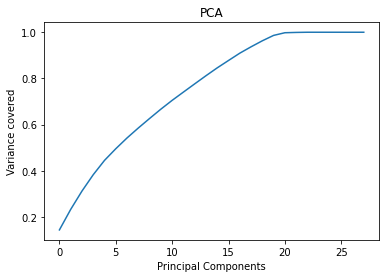

In [132]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(dt_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principal Components")
plt.ylabel("Variance covered")
plt.title("PCA")
plt.show()

In [133]:
pca = PCA(n_components=20)
principal = pca.fit_transform(dt_scaled)
principal_dt = pd.DataFrame(principal,columns=['PC1','PC2',"PC3","PC4",'PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20'])
principal_dt

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-1.970363,-0.295017,1.292830,-1.630925,-1.475229,0.478015,-0.885740,-0.393074,-0.424539,0.190958,-1.054501,-0.097685,0.442151,0.243761,0.210233,0.013676,-0.687092,-0.595348,0.714679,-1.053628
1,0.426011,0.074007,-0.547938,-0.973186,-0.477653,-0.982261,1.293065,2.260427,-1.875908,-0.138312,0.595852,0.147018,-0.295497,-1.159527,-0.447735,1.008232,-0.162344,0.402146,-0.805629,0.304409
2,-1.960116,-0.734945,-0.502899,0.578380,-0.505400,-0.463838,-1.694759,-0.184031,0.742610,0.240879,-0.917822,-0.031602,0.315911,0.811532,0.077156,-0.265233,-0.080294,-0.253230,-0.544570,-0.478989
3,-3.218037,-0.287679,0.034602,1.481891,0.553198,-0.252977,-0.189554,-1.291325,0.426385,-1.280338,0.982324,0.257934,-0.995773,-0.490749,-0.101713,0.716922,1.126004,-0.786875,-0.114742,-0.032115
4,2.463076,0.338761,0.571483,-2.535943,1.834259,-0.533457,-0.605374,-0.726190,0.373305,0.686191,-0.622180,0.023904,0.320022,0.532337,-0.238813,-0.258159,-0.652392,-2.218022,0.420484,0.780652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,0.709481,-1.188421,-1.381023,1.014946,-1.290454,-0.611769,2.372937,0.307346,0.436897,0.506202,-0.227961,-0.016930,0.368844,0.488650,0.244274,-0.377738,0.067185,-0.790189,0.530103,0.358153
2667,1.583184,0.080521,-0.882976,-0.029151,0.499933,-1.363696,0.109418,2.234442,1.104883,-0.862481,0.640797,0.239239,-0.600121,-0.102200,0.120448,0.254706,-0.207280,-0.615259,-0.179422,0.005889
2668,-1.591735,-0.067724,0.633251,-1.905837,-0.893985,0.295765,-1.015680,0.424558,-1.130818,1.342607,-0.737350,-0.168982,1.279585,1.060736,0.242791,-1.271753,-0.653049,0.349664,0.415615,0.537111
2669,-2.353509,-0.340792,0.158980,1.332136,0.085551,0.509565,2.438172,-0.629644,-0.089817,-0.392016,-1.173290,-0.253754,-0.093990,-0.145231,-0.383066,0.418440,0.792472,1.484900,0.440043,-1.103690


#### Making the prediction

In [134]:
prediction = xgbr.predict(principal_dt)

In [135]:
predict=pd.DataFrame({'Price':prediction})
predict

,Price
0,12078.382812
1,7006.785645
2,12059.833008
3,7024.855469
4,3830.178711
...,...
2666,8907.170898
2667,7898.652344
2668,7529.394043
2669,12022.870117


In [137]:
predict.to_csv("prediction.csv") #Saving as csv file

#### Saving the model

In [138]:
filename = 'Flight Price Prediction.pkl'
pickle.dump(xgbr,open(filename,'wb'))